# Doc 7 - Data augmentation, transfer learning e LR decay

Vimos a partir das documentações 6.n que ainda sim o modelo segue não aprendendo muito bem, mas tem melhorado por meio da adição do balanceamento estrito de dados (tentando igualar o número de images) somado com data augmentation.

Vamos ver agora o que acontece se colocarmos um LR variável no modelo, faznendo com que ele diminua no decorrer das épocas.

Vamos continuar usando data augmentation.

## 1 - Análise inicial de dados

In [1]:
#Imports padrão para o desenvolvimento da rede e visualização do dataset
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from tensorflow.keras.utils import to_categorical
from keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau #Interessante esse aqui - redução do LR se a validation n melhorar
from tensorflow.keras.applications import DenseNet121
from keras.applications import VGG16
from keras.models import Model
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.callbacks import LearningRateScheduler

#Imports 
import pydicom as dicom
import matplotlib.pylab as plt
import pandas as pd
import os
import numpy as np
from tabulate import tabulate
import tensorflow_io as tfio
import tensorflow as tf
import cv2
from collections import Counter
from PIL import Image
from pydicom.pixel_data_handlers.util import apply_voi_lut
import shutil
from pathlib import Path
import imagesize
import splitfolders
from sklearn.metrics import confusion_matrix
import seaborn as sns
import random

C:\Users\breno\anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


Text(0.5, 1.0, 'Frequencia de categoria one hot no dataset de teste')

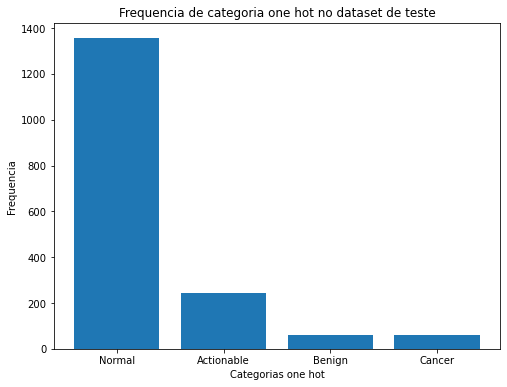

In [2]:
labels = pd.read_csv(r"D:\Coisinhas\Coisas_UNB\TCC\dataset_dcm\test\manifest-1617905855234\BCS-DBT-labels-test-PHASE-2.csv") #Arquivo dos diagnosticos

one_hot_sum = labels[['Normal', 'Actionable', 'Benign', 'Cancer']].sum()

plt.figure(figsize=(8, 6))

plt.bar(['Normal', 'Actionable', 'Benign', 'Cancer'], one_hot_sum)

plt.xlabel('Categorias one hot')
plt.ylabel('Frequencia')
plt.title('Frequencia de categoria one hot no dataset de teste')

In [3]:
one_hot_sum

Normal        1356
Actionable     244
Benign          61
Cancer          60
dtype: int64

### 1.1 - Criação do folder balanceado

In [4]:
original_folder = r"D:\Coisinhas\Coisas_UNB\TCC\dataset_png\test"
balanced_folder = r"data"

counts = {
    "normal": 60,
    "actionable": 60,
    "benign": 61,  
    "cancer": 60   
}

for category, count in counts.items():
    #Pega as classes
    category_images = os.listdir(os.path.join(original_folder, category))
    #Pega imagens aleatórias de cada classe
    random_images = random.sample(category_images, count)
    #Cria o folder da classe
    os.makedirs(os.path.join(balanced_folder, category), exist_ok=True)
    #Joga as imagens da classe no seu respectivo folder
    for image in random_images:
        shutil.copy(os.path.join(original_folder, category, image), os.path.join(balanced_folder, category))

### 1.2 - Resize das imagens

In [5]:
def resize_images(folder_path, target_size):
    for root, dirs, files in os.walk(folder_path):
        for file in files:
            if file.endswith(".png"): 
                file_path = os.path.join(root, file)
                image = Image.open(file_path)
                if image.size != target_size:
                    resized_image = image.resize(target_size, Image.ANTIALIAS)
                    resized_image.save(file_path)
                    

folder_path = r"D:\Coisinhas\Coisas_UNB\TCC\Notebooks\Doc 7 - Data augmentation, transfer learning e loss com pesos\data"
target_size = (1890, 2457) #Vamos primeiro dar o resize nas imagens que não têm essas dimensões.
resize_images(folder_path, target_size)

C:\Users\breno\AppData\Local\Temp\ipykernel_18792\2025520850.py:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  resized_image = image.resize(target_size, Image.ANTIALIAS)


In [6]:
#Agora damos um resize de 4 vezes menor.
target_size = (1890//4, 2457//4)
resize_images(folder_path, target_size)

C:\Users\breno\AppData\Local\Temp\ipykernel_18792\2025520850.py:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  resized_image = image.resize(target_size, Image.ANTIALIAS)


### 1.3 - Split do dataset

In [7]:
input_folder = 'data' 
output_folder = 'split_data' 

splitfolders.ratio(input_folder, output_folder, seed=42, ratio=(.7, .15, .15), group_prefix=None) #Train/val/test

Copying files: 241 files [00:01, 229.09 files/s]


In [8]:
train_dir = 'split_data/train' 
val_dir = 'split_data/val' 
test_dir = 'split_data/test' 

In [9]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(
    rescale=1./255
)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(1890//4, 2457//4),
    batch_size=16,
    class_mode='categorical'
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(1890//4, 2457//4),
    batch_size=16,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(1890//4, 2457//4),
    batch_size=16,
    class_mode='categorical'
)

Found 168 images belonging to 4 classes.
Found 36 images belonging to 4 classes.
Found 37 images belonging to 4 classes.


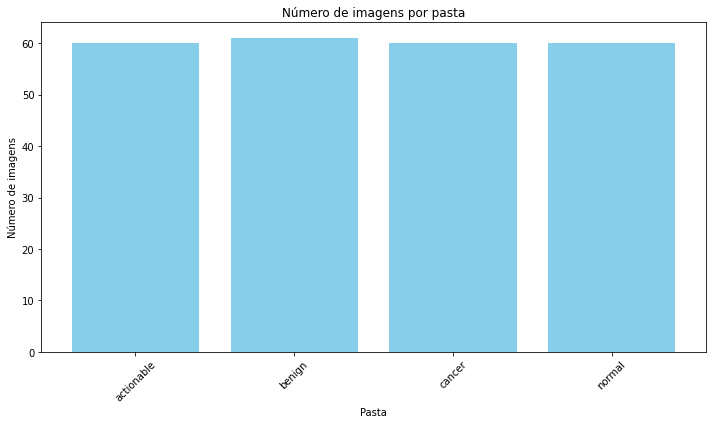

In [10]:
#Aqui é so para checar se a quantidade de imagens esta ok
folder_path = "data"

folders = ["actionable", "benign", "cancer", "normal"]

counts = []
folder_names = []

for folder in folders:
    folder_names.append(folder)
    folder_path_full = os.path.join(folder_path, folder)
    file_count = len([name for name in os.listdir(folder_path_full) if os.path.isfile(os.path.join(folder_path_full, name))])
    counts.append(file_count)

plt.figure(figsize=(10, 6))
plt.bar(folder_names, counts, color='skyblue')
plt.xlabel('Pasta')
plt.ylabel('Número de imagens')
plt.title('Número de imagens por pasta')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [11]:
counts

[60, 61, 60, 60]

## 2 - Desenvolvimento da rede

### 2.1 Otimizador com LR variável.

In [12]:
#Vai reduzir LR pela metade a cada 4 epocas
def scheduler(epoch, lr):
    if epoch % 10 == 0 and epoch != 0:
        return lr * 0.5
    else:
        return lr

#Esse vai ser o callback da rede
lr_scheduler = LearningRateScheduler(scheduler)

In [13]:
base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(1890//4, 2457//4, 3))

for layer in base_model.layers:
    layer.trainable = False
    
x = Flatten()(base_model.output)
x = Dense(128, activation='relu')(x)
predictions = Dense(4, activation='softmax')(x)


model_densenet = Model(inputs=base_model.input, outputs=predictions)

model_densenet.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

#model_densenet.summary()

In [14]:
history_densenet = model_densenet.fit(train_generator, epochs=100, validation_data=val_generator, callbacks=[lr_scheduler])

Epoch 1/100


C:\Users\breno\anaconda3\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


11/11 ━━━━━━━━━━━━━━━━━━━━ 103s 9s/step - accuracy: 0.3474 - loss: 45.0221 - val_accuracy: 0.3056 - val_loss: 28.7469 - learning_rate: 0.0010
Epoch 2/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 101s 9s/step - accuracy: 0.2285 - loss: 36.5058 - val_accuracy: 0.3056 - val_loss: 40.0765 - learning_rate: 0.0010
Epoch 3/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 90s 8s/step - accuracy: 0.3669 - loss: 22.6792 - val_accuracy: 0.3333 - val_loss: 15.1879 - learning_rate: 0.0010
Epoch 4/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 81s 7s/step - accuracy: 0.4241 - loss: 13.6272 - val_accuracy: 0.2778 - val_loss: 21.0956 - learning_rate: 0.0010
Epoch 5/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 81s 8s/step - accuracy: 0.5778 - loss: 7.3920 - val_accuracy: 0.3333 - val_loss: 11.0088 - learning_rate: 0.0010
Epoch 6/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 82s 7s/step - accuracy: 0.5727 - loss: 5.6529 - val_accuracy: 0.3056 - val_loss: 11.5485 - learning_rate: 0.0010
Epoch 7/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 80s 7s/step - accuracy: 0.4492 - loss: 5.0290 - val_acc

11/11 ━━━━━━━━━━━━━━━━━━━━ 83s 8s/step - accuracy: 0.9990 - loss: 0.0027 - val_accuracy: 0.3333 - val_loss: 7.2957 - learning_rate: 6.2500e-05
Epoch 45/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 81s 7s/step - accuracy: 1.0000 - loss: 0.0019 - val_accuracy: 0.3333 - val_loss: 5.0350 - learning_rate: 6.2500e-05
Epoch 46/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 80s 7s/step - accuracy: 1.0000 - loss: 0.0017 - val_accuracy: 0.3333 - val_loss: 6.5518 - learning_rate: 6.2500e-05
Epoch 47/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 81s 7s/step - accuracy: 1.0000 - loss: 0.0033 - val_accuracy: 0.3333 - val_loss: 5.1930 - learning_rate: 6.2500e-05
Epoch 48/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 80s 7s/step - accuracy: 1.0000 - loss: 0.0024 - val_accuracy: 0.3333 - val_loss: 4.9764 - learning_rate: 6.2500e-05
Epoch 49/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 81s 7s/step - accuracy: 1.0000 - loss: 0.0065 - val_accuracy: 0.3333 - val_loss: 7.8160 - learning_rate: 6.2500e-05
Epoch 50/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 81s 7s/step - accuracy: 1.0000 - loss

11/11 ━━━━━━━━━━━━━━━━━━━━ 80s 8s/step - accuracy: 1.0000 - loss: 0.0023 - val_accuracy: 0.3333 - val_loss: 7.1911 - learning_rate: 3.9063e-06
Epoch 88/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 82s 7s/step - accuracy: 1.0000 - loss: 0.0024 - val_accuracy: 0.3333 - val_loss: 5.7378 - learning_rate: 3.9063e-06
Epoch 89/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 81s 7s/step - accuracy: 1.0000 - loss: 0.0027 - val_accuracy: 0.3333 - val_loss: 5.7798 - learning_rate: 3.9063e-06
Epoch 90/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 81s 7s/step - accuracy: 1.0000 - loss: 0.0032 - val_accuracy: 0.3333 - val_loss: 5.2338 - learning_rate: 3.9063e-06
Epoch 91/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 80s 7s/step - accuracy: 1.0000 - loss: 0.0020 - val_accuracy: 0.3333 - val_loss: 6.2792 - learning_rate: 1.9531e-06
Epoch 92/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 81s 8s/step - accuracy: 1.0000 - loss: 0.0022 - val_accuracy: 0.3333 - val_loss: 5.7556 - learning_rate: 1.9531e-06
Epoch 93/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 81s 7s/step - accuracy: 1.0000 - loss

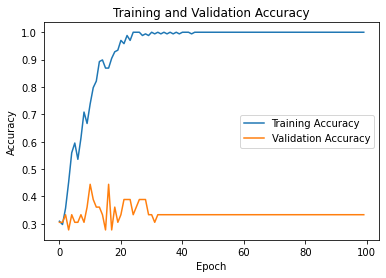

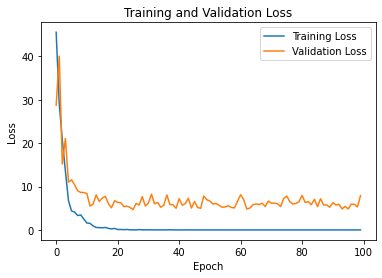

In [15]:
#Analise da precisao do treinamento e validacao
plt.plot(history_densenet.history['accuracy'], label='Training Accuracy')
plt.plot(history_densenet.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

#Analise da loss do treinamento e validacao
plt.plot(history_densenet.history['loss'], label='Training Loss')
plt.plot(history_densenet.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [16]:
test_loss, test_accuracy = model_densenet.evaluate(test_generator)

print(f'Test Accuracy: {test_accuracy * 100:.2f}%')
print(f'Test Loss: {test_loss:.4f}')

3/3 ━━━━━━━━━━━━━━━━━━━━ 14s 4s/step - accuracy: 0.1009 - loss: 8.3194
Test Accuracy: 10.81%
Test Loss: 8.9170


In [17]:
predictions = model_densenet.predict(test_generator)

#Pega os indices dos labels que foram 'predicted'
predicted_labels = np.argmax(predictions, axis=1)
predicted_labels

3/3 ━━━━━━━━━━━━━━━━━━━━ 23s 6s/step


array([0, 0, 1, 3, 0, 0, 2, 0, 1, 2, 3, 3, 1, 2, 0, 3, 2, 1, 3, 1, 2, 0,
       2, 1, 0, 0, 2, 0, 3, 1, 0, 1, 2, 2, 1, 3, 2], dtype=int64)

In [18]:
#Pega os indices corretos
true_labels = test_generator.labels
true_labels

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3])

In [19]:
#Pega os indices que foram classificados errados (i.e. vai pegar o indice dos dois arrays que estao diferentes EM VALOR)
misclassified_indices = np.where(predicted_labels != true_labels)[0]
misclassified_indices

array([ 2,  3,  6,  8,  9, 10, 11, 13, 14, 15, 16, 18, 19, 21, 23, 24, 25,
       27, 29, 30, 31, 32, 33, 34, 36], dtype=int64)

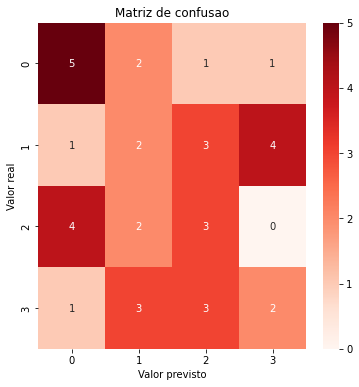

In [20]:
confusion = confusion_matrix(true_labels, predicted_labels)


plt.figure(figsize=(6, 6))
sns.heatmap(confusion, annot=True, fmt='d', cmap='Reds', xticklabels=range(4), yticklabels=range(4))
plt.xlabel('Valor previsto')
plt.ylabel('Valor real')
plt.title('Matriz de confusao')
plt.show()

In [21]:
model_densenet.save("model_densenet_lrdecay.keras")